In [2]:
%matplotlib inline
#!pip install gym
import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:

"""
Creates an epsilon-greedy policy based on a given Q-function and epsilon.

Args:
    Q: A dictionary that maps from state -> action-values.
        Each value is a numpy array of length nA (see below)
    epsilon: The probability to select a random action . float between 0 and 1.
    nA: Number of actions in the environment.

Returns:
    A function that takes the observation as an argument and returns
    the probabilities for each action in the form of a numpy array of length nA.

"""

def make_epsilon_greedy_policy(Q, epsilon, nA):
    
    def policy_fn(observation):
        actions = Q[observation]
        probs = np.full(nA, 0.0)
        for i in range(nA):
            probs[i] = epsilon/nA
        probs[np.argmax(actions)] += (1-epsilon)
        # Stick (action 0) if the score is > 20, hit (action 1) otherwise
        return probs

    return policy_fn

In [448]:
def q_diff(q_old, q_new):
    diff_list = sum(abs(q_old - q_new))
    return diff_list
    
def flatten_Q(Q):
    flattened = []
    for observation in Q:
        for action in Q[observation]:
            flattened.append(action)
    return np.array(flattened)

In [5]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

In [506]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    #returns_sum = defaultdict(lambda: defaultdict(float))
    #returns_count = defaultdict(lambda: defaultdict(float))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)   

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
  
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    # Implement this!
    timestops = [10000, 50000, 100000, 300000, 400000, 500000]
    policy_list = []
    Q_list = []
    for i in range(num_episodes):
        observation = env.reset()
        done = False
        if i%1000 == 0 and i > 10000:
            t = flatten_Q(Q.copy())
            Q_list.append(t)
        while(not done):
            actions = policy(observation)
            action = np.random.choice([0,1], p=actions)
            #action = 0
            observation2, reward, done, _ = env.step(action)
            returns_count[observation] += 1
            returns_sum[observation] += reward
            Q[observation][action] = returns_sum[observation]/returns_count[observation]
            observation = observation2
        
        policy = make_epsilon_greedy_policy(Q, epsilon/(i+1), env.action_space.n)
        if i+1 in timestops:
            policy_list.append(policy)
            print(i + 1, " : ", play(policy) *100 ,"%", "| Epsilon: ", epsilon/(i+1))
    # -----------------------------------------------------------------------
    # Question 2.1: after around 350 thousand episodes our policy converges.
    # -----------------------------------------------------------------------
    for k in range(len(Q_list)-1):
        print("diff", k, sum(abs(Q_list[k] - Q_list[k+1])))
    
    print("policies", len(policy_list))
    return Q, policy, Q_list, policy_list

In [509]:
start = time.perf_counter()

Q, policy, Q_list, policy_list = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1)

end = time.perf_counter()
print("\n",end - start,"s")

mean -0.06380982170785111 std 0.8445825069236507
10000  :  41.79 % | Epsilon:  1e-05
mean -0.07115339256230836 std 0.8475512508785995
50000  :  41.48 % | Epsilon:  2e-06
diff 0 3.5172621133816433
diff 1 2.942495170130045
diff 2 2.3086199337325697
diff 3 3.401346870278402
diff 4 2.2614621254834693
diff 5 2.75714225763842
diff 6 2.0686712926573825
diff 7 2.0398993916377366
diff 8 1.8197322526757738
diff 9 1.3304160727506242
diff 10 1.617073097889011
diff 11 1.3671906067045507
diff 12 1.3805339914620913
diff 13 1.116347063943576
diff 14 1.2161677602745948
diff 15 1.0952050430854863
diff 16 1.2242042007538925
diff 17 1.0417479718356784
diff 18 1.0370833906533654
diff 19 1.0850529562841007
diff 20 0.95127003069879
diff 21 0.8418344361603806
diff 22 0.8622175806841957
diff 23 0.8401065782185386
diff 24 0.8469757543369946
diff 25 0.7911117317886093
diff 26 0.8580342087751287
diff 27 0.8151033986647329
diff 28 0.704121988896672
diff 29 0.6711903667937354
diff 30 0.6939226737349224
diff 31 0.80

In [ ]:
# When  you are confident that you have found a good exploration schedule and a good policy,  
# prepare a  table with 6 rows (for the ETS) and 5 columns (for the statistics) for your best 
# exploration schedule and for the second best one. Then go to the peer review / discussion step
best_policy = policy_list[1]
next_best_policy = policy_list[3]
print("Best policy: ")


Test


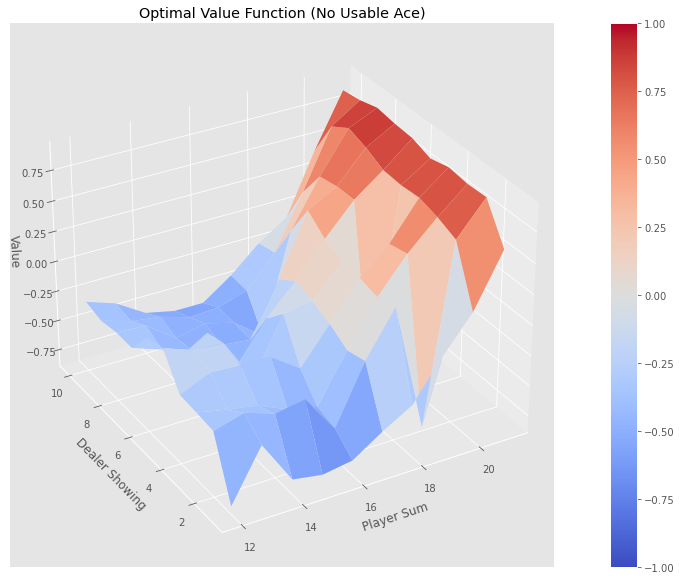

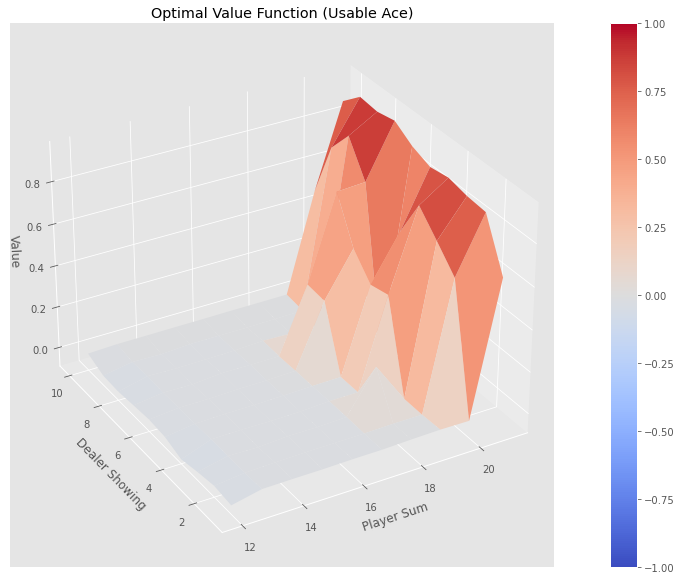

In [511]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
print("Test")
plotting.plot_value_function(V, title="Optimal Value Function")

In [426]:
def play(pol):
    resList = []
    wins = 0
    ties = 0
    losses = 0
    for i_episode in range(10000):
        observation = env.reset()
        for t in range(20):
            actions = pol(observation)
            #print("action probs", actions)
            action = np.argmax(actions)
            #print("action", action)
            observation, reward, done, _ = env.step(action)
            resList.append(reward)
            if done:
                if reward == 1:
                    wins += reward
                    #print("win!")
                elif reward == -1:
                    losses += 1
                    #print("loss :(")
                else:
                    ties += 1
                break
    print("mean", np.mean(resList), "std", np.std(resList))
    return wins/(wins+ties+losses)

In [399]:
wins = 0
losses = 0
for i_episode in range(1000):
    observation = env.reset()
    for t in range(20):
        print_observation(observation)
        action = 0
        observation, reward, done, _ = env.step(action)
        print(observation)
        if done:
            if reward == 1:
                wins += reward
                print("win!")
            elif reward == -1:
                losses += 1
                print("loss :(")
            else:
                print("draw")
            break
print(wins/(wins+losses))

Player Score: 14 (Usable Ace: False), Dealer Score: 10
(14, 10, False)
loss :(
Player Score: 15 (Usable Ace: False), Dealer Score: 6
(15, 6, False)
win!
Player Score: 17 (Usable Ace: False), Dealer Score: 5
(17, 5, False)
win!
Player Score: 13 (Usable Ace: False), Dealer Score: 6
(13, 6, False)
loss :(
Player Score: 13 (Usable Ace: False), Dealer Score: 10
(13, 10, False)
loss :(
Player Score: 18 (Usable Ace: False), Dealer Score: 3
(18, 3, False)
loss :(
Player Score: 15 (Usable Ace: False), Dealer Score: 4
(15, 4, False)
loss :(
Player Score: 13 (Usable Ace: False), Dealer Score: 3
(13, 3, False)
loss :(
Player Score: 17 (Usable Ace: False), Dealer Score: 10
(17, 10, False)
draw
Player Score: 18 (Usable Ace: False), Dealer Score: 4
(18, 4, False)
loss :(
Player Score: 14 (Usable Ace: False), Dealer Score: 9
(14, 9, False)
win!
Player Score: 16 (Usable Ace: False), Dealer Score: 3
(16, 3, False)
win!
Player Score: 16 (Usable Ace: False), Dealer Score: 10
(16, 10, False)
loss :(
Player